In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")


In [2]:

path_to_data = os.path.join('..', '..', 'data')
# load scenarios for synthetic inferences
scenarios_df = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))


In [7]:
# load posterior MLEs
RUN_IDS  = [0, 1]
γ_prior  = [0.01, 0.9]
β_prior  = [0.001, 0.05]

param_prior_dict      = {}
param_prior_dict["γ"] = γ_prior
param_prior_dict["β"] = β_prior

ρ = 6
posterior_df = []
for idx_oev, run_id in enumerate(RUN_IDS):
    for idx_row, row in scenarios_df.iterrows():
        s_name      = row.name_scenario

        path_to_scenario = os.path.join('..', '..', 'results', 'synthetic_inferences', f'ρ_{ρ}%', row.name_scenario)
        name_sims_save      = f'inference_{run_id}.npz'
        samples          = np.load( os.path.join(path_to_scenario, name_sims_save) )


        para_post_all    = samples["param_posterior"]
        param_mean_iter  = samples["theta"]
        param_mean_iter  = param_mean_iter[[0,1],:]
        para_post_iter   = para_post_all.mean(-2) # average over time

        params_label     = [r"$\gamma$", r"$\beta$"]
        truth_list       = [row['γ'], row['β']]

        param_range      = list(param_prior_dict.values())
        gamma_mle        = para_post_iter[0,:,-1]
        beta_mle         = para_post_iter[1,:,-1]

        p_df                = pd.DataFrame(columns=["gamma", "beta", "scenario"])
        p_df["gamma"]       = gamma_mle
        p_df["beta"]        = beta_mle

        p_df["gamma_truth"] = truth_list[0]
        p_df["beta_truth"]  = truth_list[1]

        p_df["scenario"] = "Scenario " + str(idx_row+1)
        p_df["run_id"]   = run_id

        posterior_df.append(p_df)

posterior_df             = pd.concat(posterior_df, ignore_index=True)
posterior_df["type"]     = "MLE"
posterior_df["type_plt"] = posterior_df.apply(lambda x: x.type + " " + str(x.run_id), axis=1)


In [8]:
# Plotting stuff
import seaborn as sns
from utils.plot_utils import *

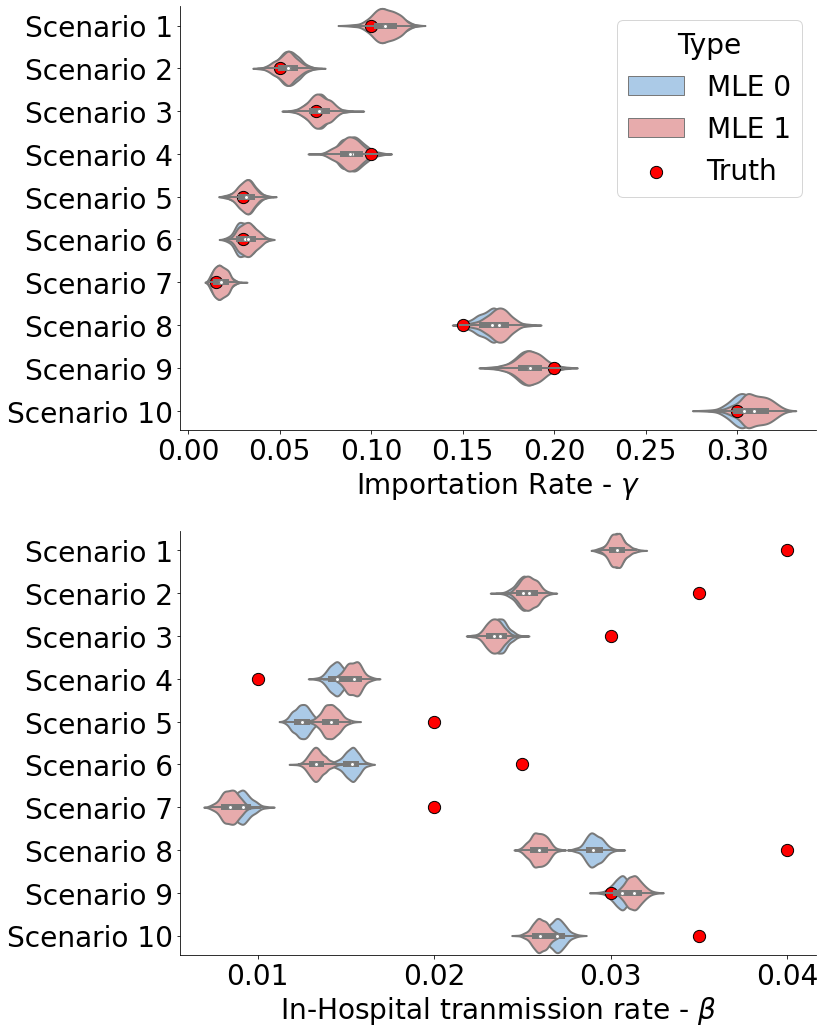

In [10]:
# First figure: Violin plots MLEs
fig_dims = figure_size_setting(1600)
fig, ax = plt.subplots(2, 1, figsize=(12.2, 15), sharey=True)

run_id = 0
sns.violinplot(ax=ax[0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5)
sns.violinplot(ax=ax[1], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#a1caf1", "#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5)

run_id = 1
sns.violinplot(ax=ax[0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)
sns.violinplot(ax=ax[1], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#f1a1a2", "#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)

#run_id = 3
#sns.violinplot(ax=ax[0], data=posterior_df[posterior_df.run_id==run_id], x="gamma", y="scenario", hue="type_plt", palette=["#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)
#sns.violinplot(ax=ax[1], data=posterior_df[posterior_df.run_id==run_id], x="beta",  y="scenario", hue="type_plt", palette=["#a1a2f1"], linewidth=2, edgecolor="k", alpha=0.5, label=None)

#sns.scatterplot(ax=ax[0], data=posterior_df.groupby("scenario").mean(), x="gamma", y="scenario", s=150, facecolor="green", edgecolor="k", marker="^", label="MLE", lw=20)
#sns.scatterplot(ax=ax[1], data=posterior_df.groupby("scenario").mean(), x="beta", y="scenario", s=150, facecolor="green", edgecolor="k", marker="^", label="MLE", lw=20)

sns.scatterplot(ax=ax[0], data=posterior_df.drop_duplicates(subset="scenario", keep="first"), x="gamma_truth", y="scenario", s=150, facecolor="red", edgecolor="k", marker="o", label="Truth", lw=20)
sns.scatterplot(ax=ax[1], data=posterior_df.drop_duplicates(subset="scenario", keep="first"), x="beta_truth", y="scenario",  s=150, facecolor="red", edgecolor="k", marker="o", label="Truth",  lw=20)

ax[0].legend(title="Type", loc="upper right")

sns.despine(right=True, top=True)

ax[1].legend().remove()
ax[0].set_xlabel(r"Importation Rate - $\gamma$")
ax[1].set_xlabel(r"In-Hospital tranmission rate - $\beta$")
ax[0].set_ylabel(None)
ax[1].set_ylabel(None)

xlims_upp   = ax[0].get_xlim()
xlims_downn = ax[1].get_xlim()

plt.tight_layout()
